# Test of Chunks, zarr, kerchunk, remote, POSIX, OSDF, Spectrum Scale S3, etc., etc.

In [3]:
import sys
import os
import glob
import math
import xarray
import dask
from random import randint
from dask.distributed import Client, progress
import pandas
import logging

### Start up dask

In [2]:
client = Client(threads_per_worker=4, n_workers=4, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/8787/status,Workers: 4
Total threads: 16,Total memory: 16.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:37115,Workers: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/8787/status,Total threads: 16
Started: Just now,Total memory: 16.00 GiB
Comm: tcp://127.0.0.1:33417,Total threads: 4
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/rpconroy/proxy/33587/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:44489,


# NetCDF4 Chunk Tests

#### First, let's start by comparing large chunks vs small chunks vs default vs normalized
In this case I'll use a couple weeks worth of ERA5 Temperature data

In [3]:
large_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/big_chunks/'
large_chunks_files = glob.glob(large_chunks_path+'*')
large_chunks_files.sort()
small_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/little_chunks/'
small_chunks_files = glob.glob(small_chunks_path+'*')
small_chunks_files.sort()
even_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/even_chunks/'
even_chunks_files = glob.glob(even_chunks_path+'*')
even_chunks_files.sort()
default_chunks_path = '/glade/derecho/scratch/rpconroy/era5_chunks/default_chunks/'
default_chunks_files = glob.glob(default_chunks_path+'*')
default_chunks_files.sort()
print(f'Number of files: {len(default_chunks_files)}')
print(f'Typical size ~{math.floor(os.path.getsize(default_chunks_files[0])/1000000)} MB')

Number of files: 31
Typical size ~1262 MB


### default chunks

In [4]:
sample_file_DC = default_chunks_files[0]
print(os.path.basename(sample_file_DC))
DC_ds = xarray.open_dataset(sample_file_DC)
print(f"Chunksizes are: {DC_ds.T.encoding['chunksizes']}")
print(f"shape is: {DC_ds.T.shape}")
chunk_size =  1
for i in DC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

e5.oper.an.pl.128_130_t.ll025sc.1966010100_1966010123.nc
Chunksizes are: (1, 37, 721, 1440)
shape is: (24, 37, 721, 1440)
Approximate size of uncompressed chunk: 153.65952 MB


### large chunks

In [5]:
sample_file_LC = large_chunks_files[0]
print(os.path.basename(sample_file_LC))
LC_ds = xarray.open_dataset(sample_file_LC)
print(f"Chunksizes are: {LC_ds.T.encoding['chunksizes']}")
print(f"shape is: {LC_ds.T.shape}")
chunk_size =  1
for i in LC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

e5.oper.an.pl.128_130_t.ll025sc.1966010100_1966010123.nc
Chunksizes are: (24, 37, 721, 1440)
shape is: (24, 37, 721, 1440)
Approximate size of uncompressed chunk: 3687.82848 MB


### small chunks

In [6]:
sample_file_SC = small_chunks_files[0]
print(os.path.basename(sample_file_SC))
SC_ds = xarray.open_dataset(sample_file_SC)
print(f"Chunksizes are: {SC_ds.T.encoding['chunksizes']}")
print(f"shape is: {SC_ds.T.shape}")
chunk_size =  1
for i in SC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

e5.oper.an.pl.128_130_t.ll025sc.1966010100_1966010123.nc
Chunksizes are: (1, 1, 100, 100)
shape is: (24, 37, 721, 1440)
Approximate size of uncompressed chunk: 0.04 MB


### even chunks

In [7]:
sample_file_EC = even_chunks_files[0]
print(os.path.basename(sample_file_EC))
EC_ds = xarray.open_dataset(sample_file_EC)
print(f"Chunksizes are: {EC_ds.T.encoding['chunksizes']}")
print(f"shape is: {EC_ds.T.shape}")
chunk_size =  1
for i in EC_ds.T.encoding['chunksizes']: chunk_size*=i
print(f"Approximate size of uncompressed chunk: {chunk_size*4/1000**2} MB")

e5.oper.an.pl.128_130_t.ll025sc.1966010100_1966010123.nc
Chunksizes are: (8, 9, 180, 360)
shape is: (24, 37, 721, 1440)
Approximate size of uncompressed chunk: 18.6624 MB


## Make some measurements

#### Single point

In [8]:
%%timeit -r1 -n1 -o
val = DC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

279.0929
687 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 687 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [9]:
DC_single_point = _.average

In [10]:
%%timeit -r1 -n1 -o
val = LC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

279.31747
15.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [11]:
LC_single_point = _.average

In [12]:
%%timeit -r1 -n1 -o
val = SC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

278.4477
43.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 43.8 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [13]:
SC_single_point = _.average

In [14]:
%%timeit -r1 -n1 -o
val = EC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.data)

279.4439
135 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 135 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [15]:
EC_single_point = _.average

<Axes: >

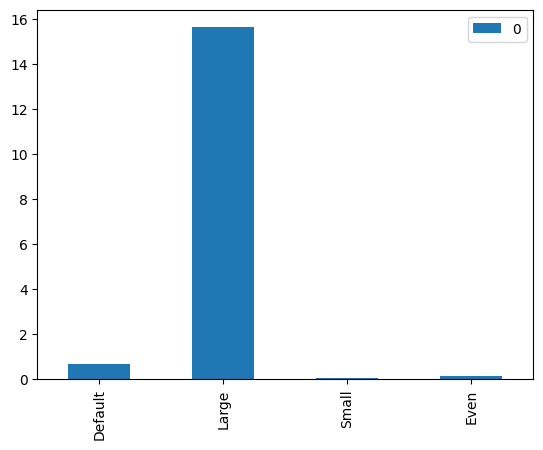

In [16]:
df = pandas.DataFrame(data=[DC_single_point,LC_single_point,SC_single_point,EC_single_point],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

<Axes: >

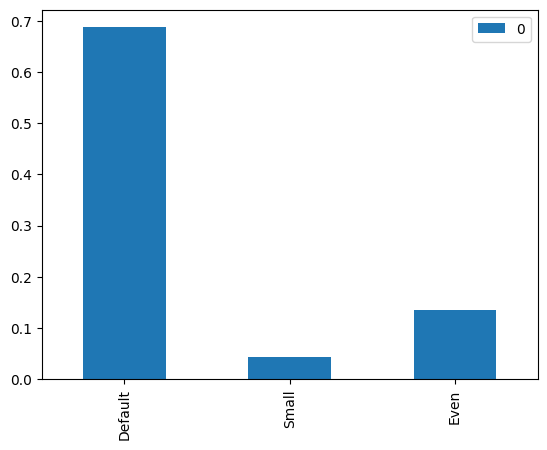

In [17]:
df = pandas.DataFrame(data=[DC_single_point,SC_single_point,EC_single_point],
                index=['Default','Small','Even'])
df.plot(kind='bar')

#### Full grid

825 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 825 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

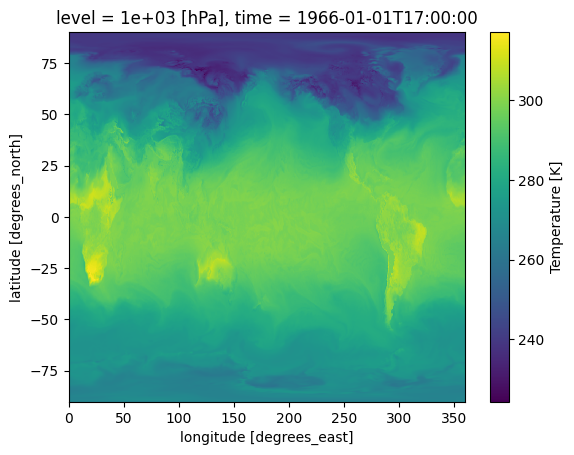

In [18]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(time=randint(0,24),level=36).plot()

In [19]:
DC_full_grid = _.average

15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

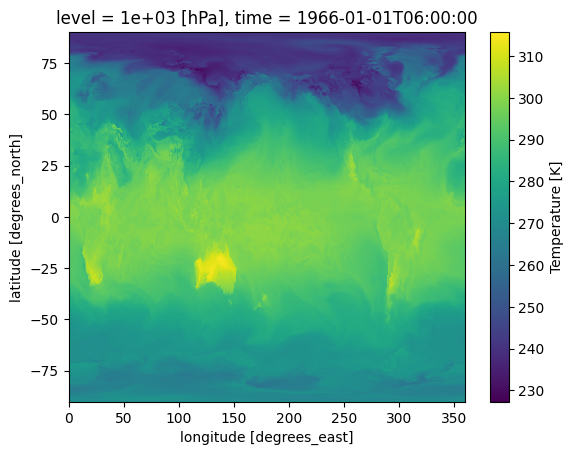

In [20]:
%%timeit -r1 -n1 -o
LC_ds.T.isel(time=randint(0,24),level=36).plot()

In [21]:
LC_full_grid = _.average

232 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 232 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

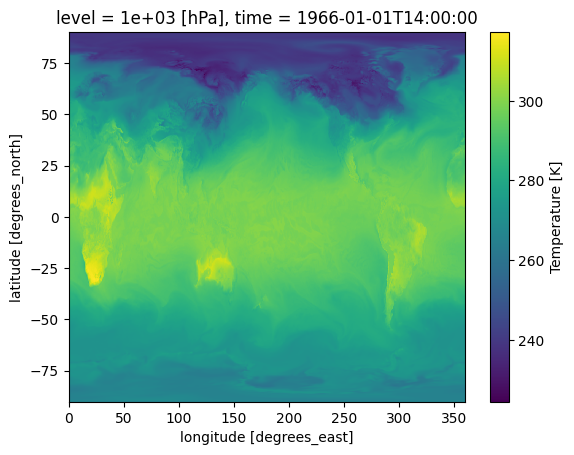

In [22]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(time=randint(0,24),level=36).plot()

In [23]:
SC_full_grid = _.average

1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 1.11 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

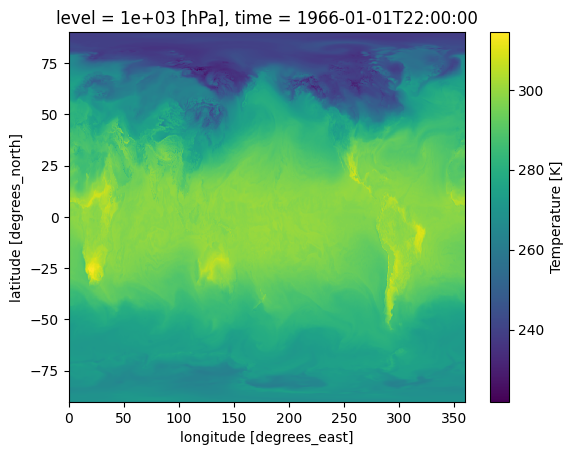

In [24]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(time=randint(0,24), level=36).plot()

In [25]:
EC_full_grid = _.average

<Axes: >

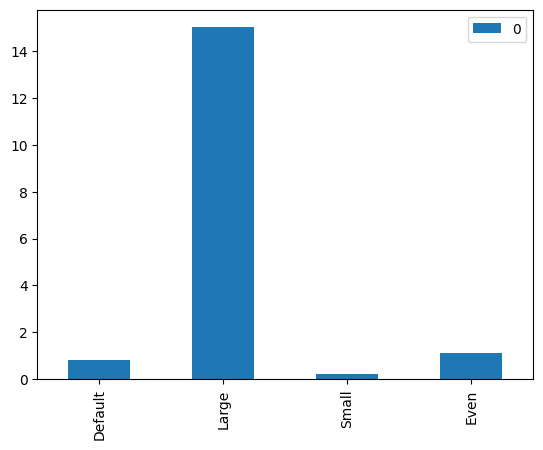

In [26]:
df = pandas.DataFrame(data=[DC_full_grid,LC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

<Axes: >

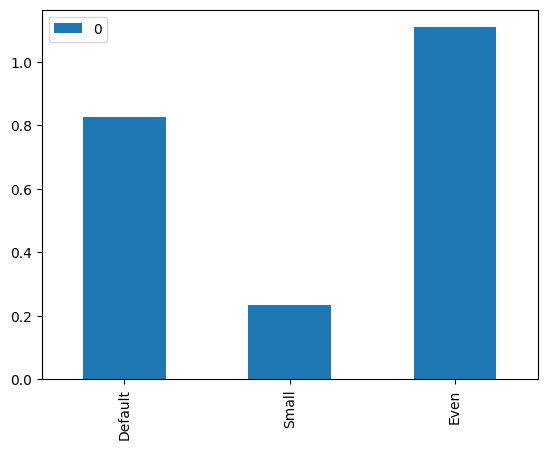

In [27]:
df = pandas.DataFrame(data=[DC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default','Small','Even'])
df.plot(kind='bar')

#### Time Series

15.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

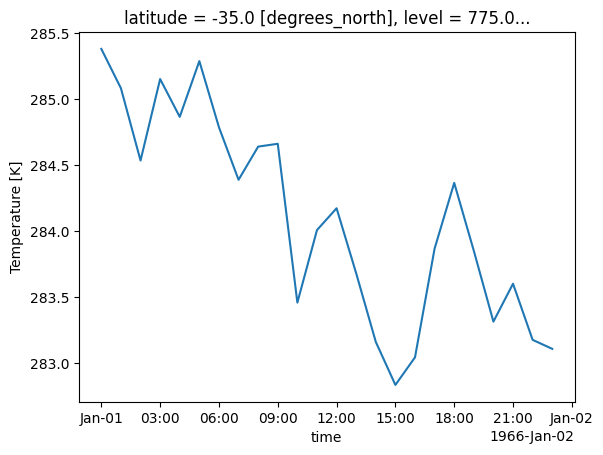

In [28]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(level=27,latitude=500, longitude=500).plot()


In [29]:
DC_timeseries = _.average

14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 14.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

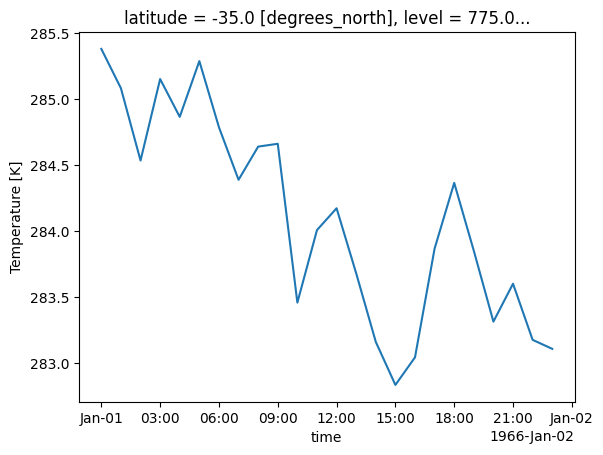

In [30]:
%%timeit -r1 -n1 -o
LC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [31]:
LC_timeseries = _.average

781 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 781 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

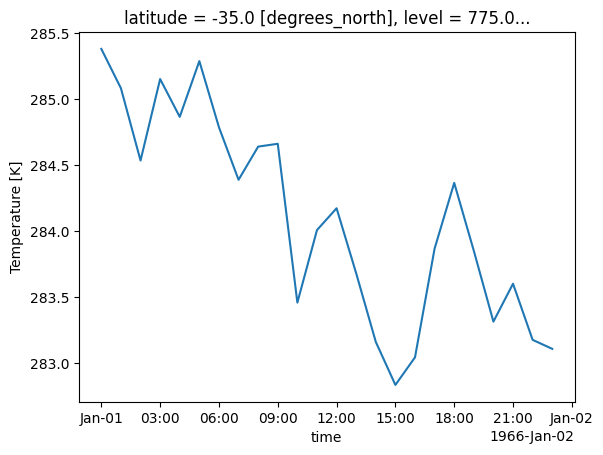

In [32]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [33]:
SC_timeseries = _.average

330 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 330 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

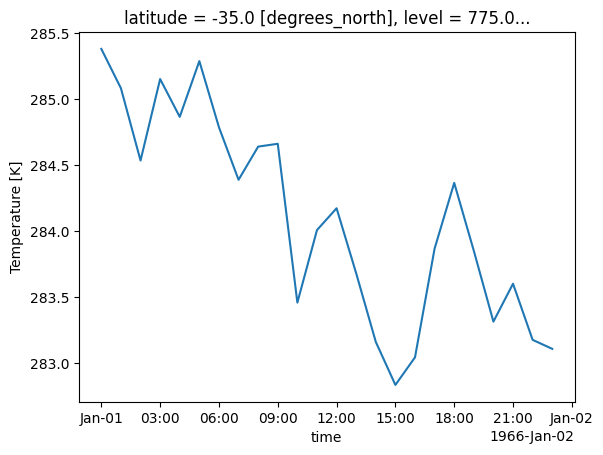

In [34]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(level=27,latitude=500, longitude=500).plot()

In [35]:
EC_timeseries = _.average

<Axes: >

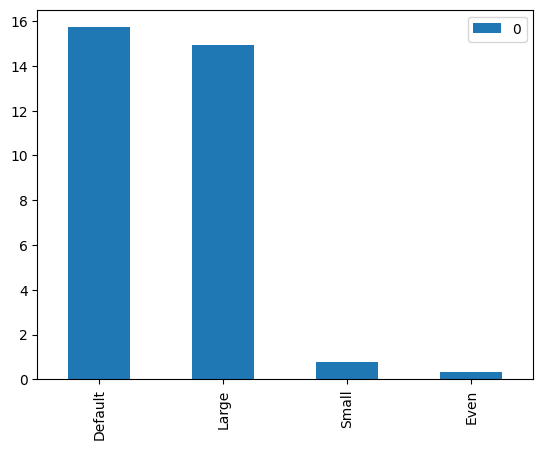

In [36]:
df = pandas.DataFrame(data=[DC_timeseries,LC_timeseries,SC_timeseries,EC_timeseries],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

### Full file

In [37]:
%%timeit -r1 -n1 -o
print(DC_ds.T.mean().data)

246.62447
21.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 21.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [38]:
DC_full = _.average

In [39]:
%%timeit -r1 -n1 -o
print(LC_ds.T.mean().data)

246.62447
21.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 21.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [40]:
LC_full = _.average

In [41]:
%%timeit -r1 -n1 -o
print(SC_ds.T.mean().data)

246.62447
38.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 38.1 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [42]:
SC_full = _.average

In [43]:
%%timeit -r1 -n1 -o
print(EC_ds.T.mean().data)

246.62447
28.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 28.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [44]:
EC_full = _.average

<Axes: >

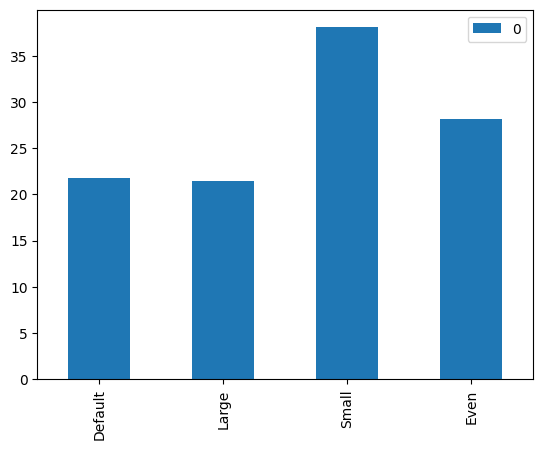

In [45]:
df = pandas.DataFrame(data=[DC_full,LC_full,SC_full,EC_full],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

### Test combined datasets

In [46]:
%%time
ds = xarray.open_mfdataset(small_chunks_path+'*')
ds

CPU times: user 3.81 s, sys: 529 ms, total: 4.34 s
Wall time: 9.01 s


<xarray.Dataset> Size: 114GB
Dimensions:    (time: 744, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1966-01-01 ... 1966-01-31T23:00:00
Data variables:
    T          (time, level, latitude, longitude) float32 114GB dask.array<chunksize=(1, 1, 100, 100), meta=np.ndarray>
    utc_date   (time) int32 3kB dask.array<chunksize=(24,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r5i0n19 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Thu Aug 18 06:53:33 MDT 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Thu Aug 18 06:54:06 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

CPU times: user 4.37 s, sys: 180 ms, total: 4.55 s
Wall time: 5.15 s


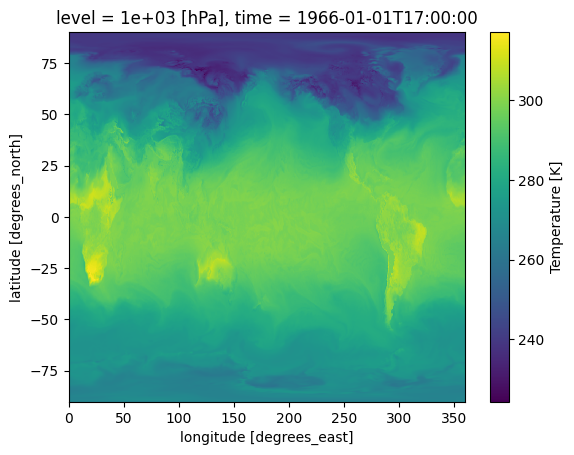

In [47]:
%%time
ds.T.isel(time=randint(0,24),level=36).plot()

CPU times: user 5.74 s, sys: 278 ms, total: 6.02 s
Wall time: 11.5 s


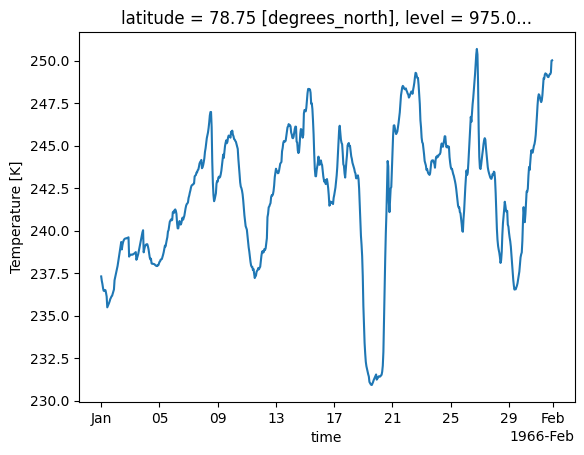

In [48]:
%%time
ds.T.isel(level=35,latitude=45, longitude=500).plot()

In [49]:
%%time
ds = xarray.open_mfdataset(large_chunks_path+'*')
ds

CPU times: user 395 ms, sys: 170 ms, total: 565 ms
Wall time: 2.36 s


<xarray.Dataset> Size: 114GB
Dimensions:    (time: 744, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1966-01-01 ... 1966-01-31T23:00:00
Data variables:
    T          (time, level, latitude, longitude) float32 114GB dask.array<chunksize=(24, 37, 721, 1440), meta=np.ndarray>
    utc_date   (time) int32 3kB dask.array<chunksize=(24,), meta=np.ndarray>
Attributes:
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    CONVERSION_PLATFORM:  Linux r5i0n19 4.12.14-95.51-default #1 SMP Fri Apr ...
    CONVERSION_DATE:      Thu Aug 18 06:53:33 MDT 2022
    Conventions:          CF-1.6
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    history:              Thu Aug 18 06:54:06 2022: ncks -4 --ppc default=7 e...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...

# Campaign vs Luster 

In [50]:
default_chunks_path_luster = '/glade/derecho/scratch/rpconroy/era5_chunks/default_chunks/'
default_chunks_files_luster = glob.glob(default_chunks_path_luster+'*')
ds_luster = xarray.open_mfdataset(default_chunks_files_luster)

In [51]:
default_chunks_path_cs = '/gpfs/csfs1/collections/rda/data/harshah/rpconroy/era5_chunks/default_chunks/'
default_chunks_files_cs = glob.glob(default_chunks_path_cs+'*')
ds_campaign = xarray.open_mfdataset(default_chunks_files_cs)

In [52]:
little_chunks_path_luster = '/glade/derecho/scratch/rpconroy/era5_chunks/little_chunks/'
little_chunks_files_luster = glob.glob(little_chunks_path_luster+'*')
ds_luster_mc = xarray.open_mfdataset(little_chunks_files_luster)

In [53]:
little_chunks_path_cs = '/gpfs/csfs1/collections/rda/data/harshah/rpconroy/era5_chunks/little_chunks/'
little_chunks_files_cs = glob.glob(little_chunks_path_luster+'*')
ds_campaign_mc = xarray.open_mfdataset(little_chunks_files_cs)

50.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 50.9 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

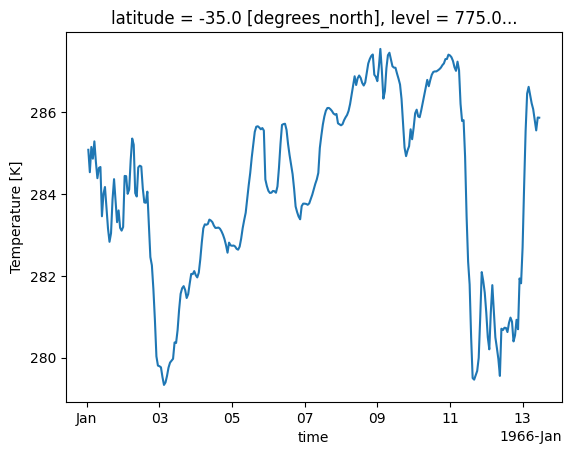

In [54]:
%%timeit -r1 -n1 -o
ds_campaign.T.isel(time=slice(1,300),level=27,latitude=500, longitude=500).plot()

In [55]:
campaign_time = _.average

In [56]:
%%timeit -r1 -n1 -o
print(ds_campaign_mc.T.isel(time=slice(1,300),level=27).mean().compute())

<xarray.DataArray 'T' ()> Size: 4B
array(269.72464, dtype=float32)
Coordinates:
    level    float64 8B 775.0
57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 57.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [57]:
campaign_time_mc = _.average

53.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 53.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

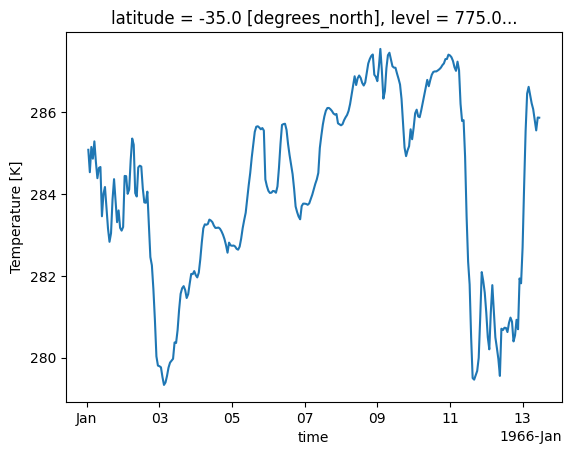

In [58]:
%%timeit -r1 -n1 -o
ds_luster.T.isel(time=slice(1,300),level=27,latitude=500, longitude=500).plot()

In [59]:
luster_time = _.average

In [60]:
%%timeit -r1 -n1 -o
print(ds_luster_mc.T.isel(time=slice(300,600),level=27).mean().load())

<xarray.DataArray 'T' ()> Size: 4B
array(269.72464, dtype=float32)
Coordinates:
    level    float64 8B 775.0
45.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 45.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [61]:
luster_time_mc = _.average

<Axes: >

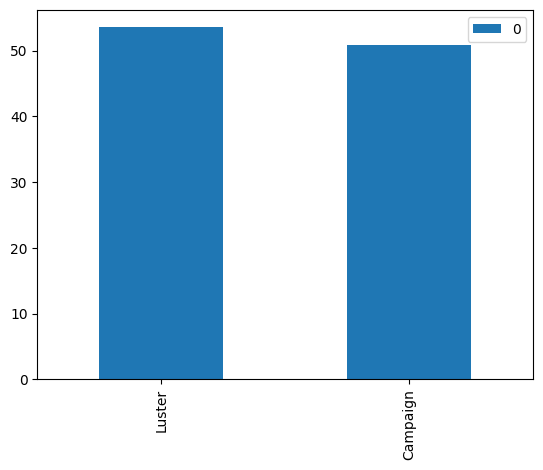

In [62]:
df = pandas.DataFrame(data=[luster_time, campaign_time],
                index=['Luster', 'Campaign'])
df.plot(kind='bar')                                                                                                                                                                                              

<Axes: >

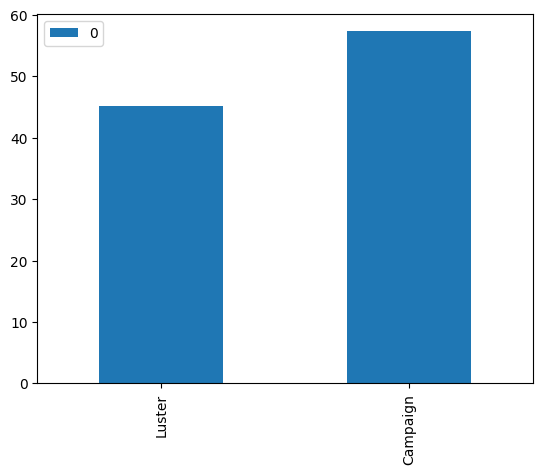

In [63]:
df = pandas.DataFrame(data=[luster_time_mc, campaign_time_mc],
                index=['Luster', 'Campaign'])
df.plot(kind='bar')        

# Kerchunk Tests

In [64]:
catalog_root = 'https://data.rda.ucar.edu/harshah/rpconroy/era5_chunks/'                          
LC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'big_chunks-remote.json'}, 'consolidated':False},chunks=False)
DC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'default_chunks-remote.json'}, 'consolidated':False},chunks=False)
EC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'even_chunks-remote.json'}, 'consolidated':False},chunks=False)

Opening the small reference file separately. This file is about 1 GB in size!

In [65]:
SC_ds = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'little_chunks-remote.json'}, 'consolidated':False},chunks=False)

In [66]:
DC_ds

<xarray.Dataset> Size: 114GB
Dimensions:    (time: 744, level: 37, latitude: 721, longitude: 1440)
Coordinates:
  * latitude   (latitude) float64 6kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) float64 296B 1.0 2.0 3.0 5.0 ... 925.0 950.0 975.0 1e+03
  * longitude  (longitude) float64 12kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 6kB 1966-01-01 ... 1966-01-31T23:00:00
Data variables:
    T          (time, level, latitude, longitude) float32 114GB dask.array<chunksize=(8, 9, 180, 360), meta=np.ndarray>
    utc_date   (time) int32 3kB dask.array<chunksize=(8,), meta=np.ndarray>
Attributes:
    CONVERSION_DATE:      Thu Aug 18 07:41:03 MDT 2022
    CONVERSION_PLATFORM:  Linux r1i5n29 4.12.14-95.51-default #1 SMP Fri Apr ...
    Conventions:          CF-1.6
    DATA_SOURCE:          ECMWF: https://cds.climate.copernicus.eu, Copernicu...
    NCO:                  netCDF Operators version 5.0.3 (Homepage = http://n...
    NETCDF_COMPRESSION:   NCO: Precision-preserving compression to netCDF4/HD...
    NETCDF_CONVERSION:    CISL RDA: Conversion from ECMWF GRIB 1 data to netC...
    NETCDF_VERSION:       4.8.1
    history:              Thu Aug 18 07:41:34 2022: ncks -4 --ppc default=7 e...

## Make some measurements

#### Single point

Note that for all of these functions I have forced Dask to work Serially.

Allowing Dask to try to parallel process either crashes the worker (due to memory limits)
or takes ~2-3x as long to compute.

In [67]:
%%timeit -r1 -n1 -o
val = DC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.compute(scheduler='single-threaded'))

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


<xarray.DataArray 'T' ()> Size: 4B
array(279.40338, dtype=float32)
Coordinates:
    latitude   float64 8B -35.0
    level      float64 8B 700.0
    longitude  float64 8B 125.0
    time       datetime64[ns] 8B 1966-01-01T18:00:00
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    130
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          Temperature
    maximum_value:                                      315.8389587402344
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric pres...
    rda_dataset_url:                                    https:/rda

<TimeitResult : 1.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [68]:
DC_single_point_KC = _.average

Dask needs to be single threaded or it will run into memory limits for this call

In [69]:
%%timeit -r1 -n1 -o
val = LC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.compute(scheduler='single-threaded'))

<xarray.DataArray 'T' ()> Size: 4B
array(280.35156, dtype=float32)
Coordinates:
    latitude   float64 8B -35.0
    level      float64 8B 700.0
    longitude  float64 8B 125.0
    time       datetime64[ns] 8B 1966-01-01T03:00:00
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    130
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          Temperature
    maximum_value:                                      315.8389587402344
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric pres...
    rda_dataset_url:                                    https:/rda

<TimeitResult : 20.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [70]:
LC_single_point_KC = _.average

In [71]:
%%timeit -r1 -n1 -o
val = SC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.compute(scheduler='single-threaded'))

<xarray.DataArray 'T' ()> Size: 4B
array(279.8747, dtype=float32)
Coordinates:
    latitude   float64 8B -35.0
    level      float64 8B 700.0
    longitude  float64 8B 125.0
    time       datetime64[ns] 8B 1966-01-01T05:00:00
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    130
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          Temperature
    maximum_value:                                      315.8389587402344
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric pres...
    rda_dataset_url:                                    https:/rda.

<TimeitResult : 4.03 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [72]:
SC_single_point_KC = _.average

In [73]:
%%timeit -r1 -n1 -o
val = EC_ds.isel(time=randint(0,23),level=25,latitude=500, longitude=500)
print(val.T.compute(scheduler='single-threaded'))

<xarray.DataArray 'T' ()> Size: 4B
array(279.40338, dtype=float32)
Coordinates:
    latitude   float64 8B -35.0
    level      float64 8B 700.0
    longitude  float64 8B 125.0
    time       datetime64[ns] 8B 1966-01-01T18:00:00
Attributes: (12/14)
    QuantizeGranularBitGroomNumberOfSignificantDigits:  7
    ecmwf_local_table:                                  128
    ecmwf_parameter:                                    130
    grid_specification:                                 0.25 degree x 0.25 de...
    long_name:                                          Temperature
    maximum_value:                                      315.8389587402344
    ...                                                 ...
    rda_dataset:                                        ds633.0
    rda_dataset_doi:                                    DOI: 10.5065/BH6N-5N20
    rda_dataset_group:                                  ERA5 atmospheric pres...
    rda_dataset_url:                                    https:/rda

<TimeitResult : 378 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [74]:
EC_single_point_KC = _.average

<Axes: >

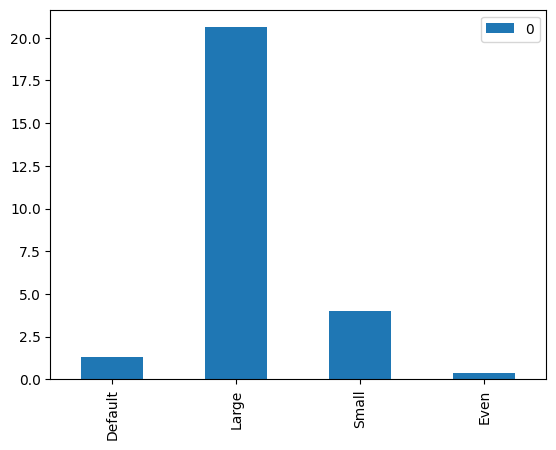

In [75]:
df = pandas.DataFrame(data=[DC_single_point_KC,LC_single_point_KC,SC_single_point_KC,EC_single_point_KC],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

<Axes: >

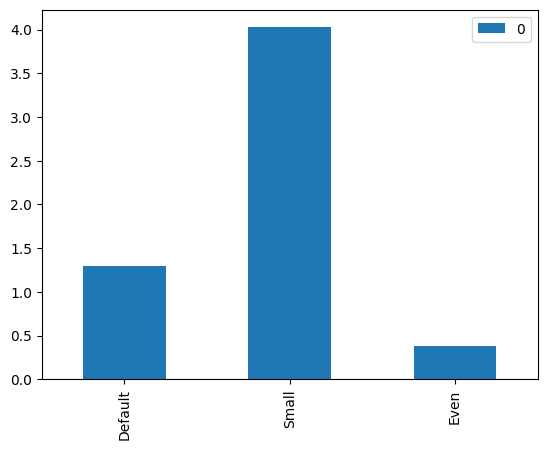

In [76]:
df = pandas.DataFrame(data=[DC_single_point_KC,SC_single_point_KC,EC_single_point_KC],
                index=['Default','Small','Even'])
df.plot(kind='bar')

<Axes: >

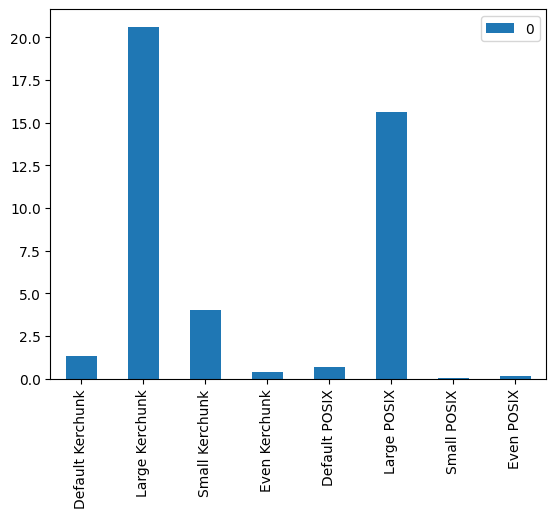

In [77]:
df = pandas.DataFrame(data=[DC_single_point_KC,LC_single_point_KC,SC_single_point_KC,EC_single_point_KC,DC_single_point,LC_single_point,SC_single_point,EC_single_point],
                index=['Default Kerchunk','Large Kerchunk','Small Kerchunk','Even Kerchunk','Default POSIX','Large POSIX', 'Small POSIX','Even POSIX' ])
df.plot(kind='bar')

<Axes: >

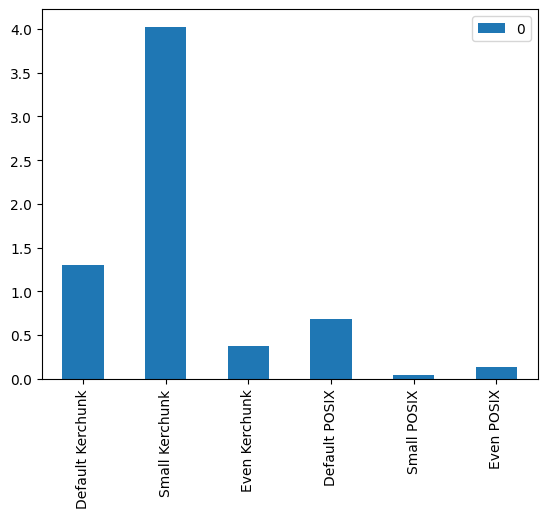

In [78]:
df = pandas.DataFrame(data=[DC_single_point_KC,SC_single_point_KC,EC_single_point_KC,DC_single_point,SC_single_point,EC_single_point],
                index=['Default Kerchunk','Small Kerchunk','Even Kerchunk','Default POSIX', 'Small POSIX','Even POSIX' ])
df.plot(kind='bar')

#### Full grid

3.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 3.89 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

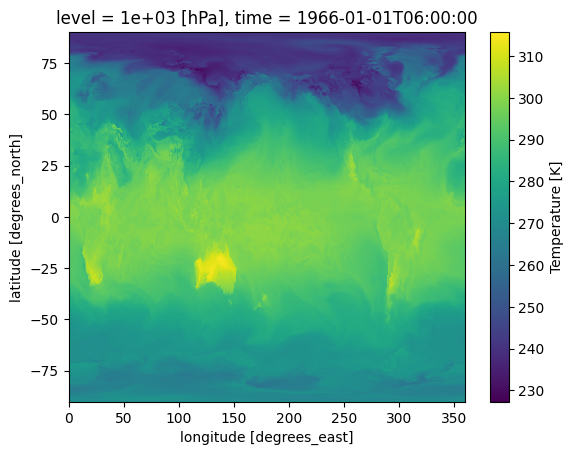

In [79]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(time=randint(0,24),level=36).plot()

In [80]:
DC_full_grid_KC = _.average

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


20.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 20.7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

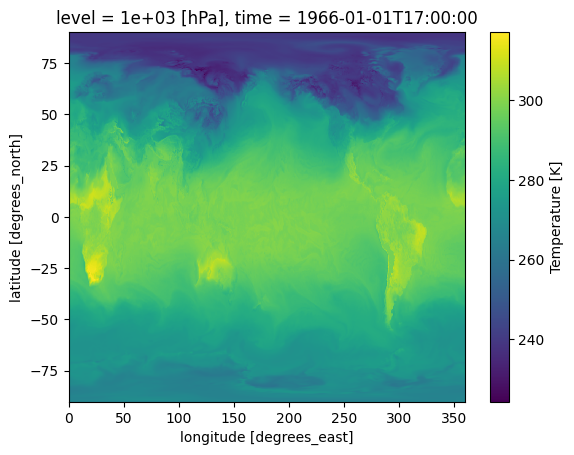

In [81]:
%%timeit -r1 -n1 -o
with dask.config.set(scheduler='single-threaded'):
    LC_ds.T.isel(time=randint(0,24),level=36).plot()

In [82]:
LC_full_grid_KC = _.average

43.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 43.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

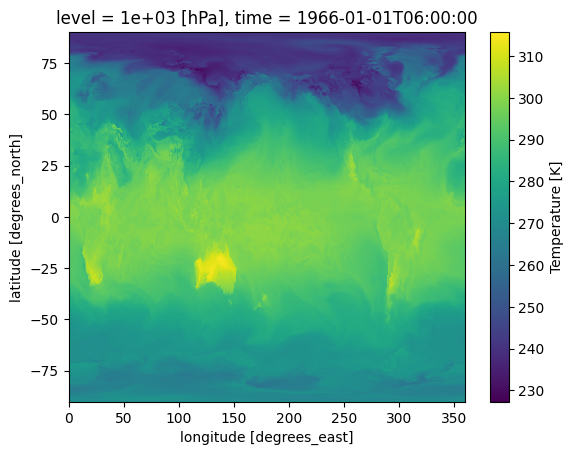

In [83]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(time=randint(0,24),level=36).plot()

In [84]:
SC_full_grid_KC = _.average

4.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 4.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

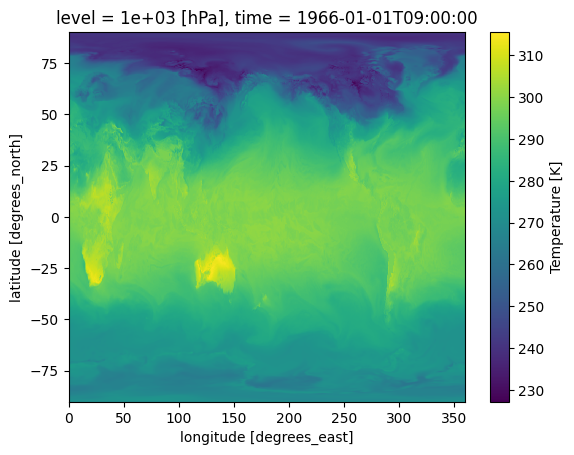

In [85]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(time=randint(0,24), level=36).plot()

In [86]:
EC_full_grid_KC = _.average

<Axes: >

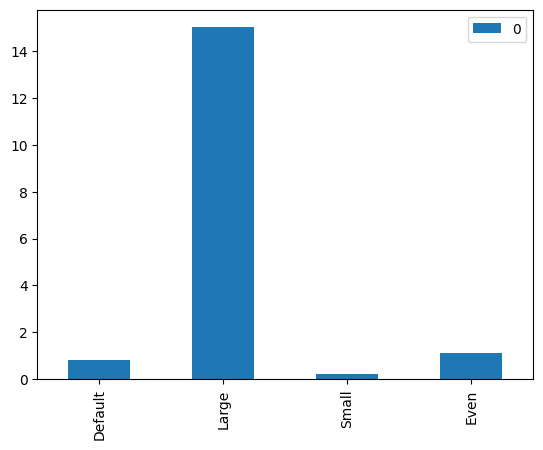

In [87]:
df = pandas.DataFrame(data=[DC_full_grid_KC,LC_full_grid_KC,SC_full_grid_KC,EC_full_grid_KC],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

<Axes: >

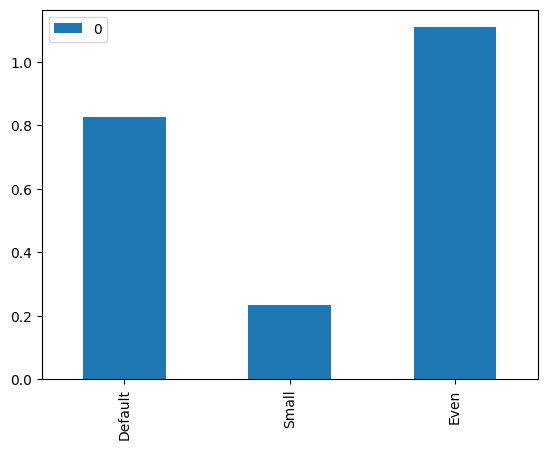

In [88]:
df = pandas.DataFrame(data=[DC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default','Small','Even'])
df.plot(kind='bar')

<Axes: >

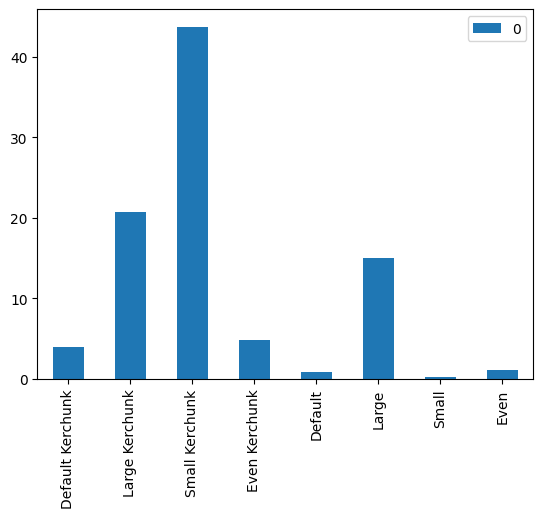

In [89]:
df = pandas.DataFrame(data=[DC_full_grid_KC,LC_full_grid_KC,SC_full_grid_KC,EC_full_grid_KC, DC_full_grid,LC_full_grid,SC_full_grid,EC_full_grid],
                index=['Default Kerchunk','Large Kerchunk','Small Kerchunk','Even Kerchunk','Default','Large','Small','Even'])
df.plot(kind='bar')

#### Time Series

7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 7 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

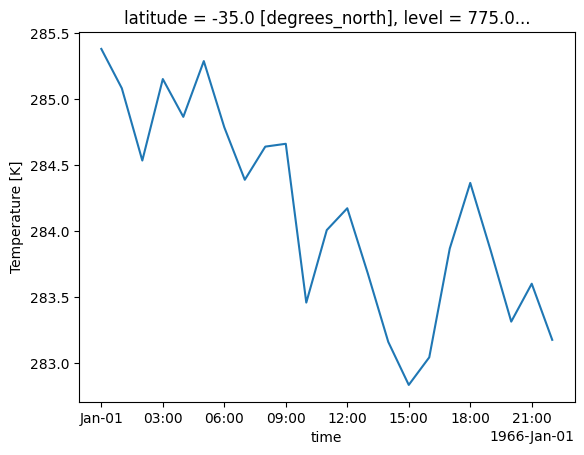

In [90]:
%%timeit -r1 -n1 -o
DC_ds.T.isel(time=slice(0,23),level=27,latitude=500, longitude=500).plot()


In [91]:
DC_timeseries_KC = _.average

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


21.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 21.3 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

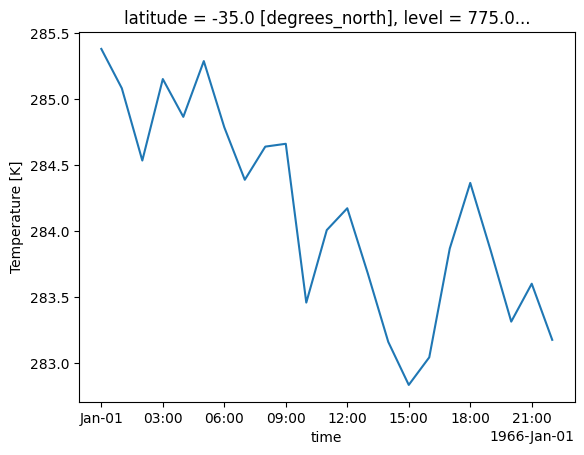

In [92]:
%%timeit -r1 -n1 -o
with dask.config.set(scheduler='single-threaded'):
    LC_ds.T.isel(time=slice(0,23),level=27,latitude=500, longitude=500).plot()

In [93]:
LC_timeseries_KC = _.average

4.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 4.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

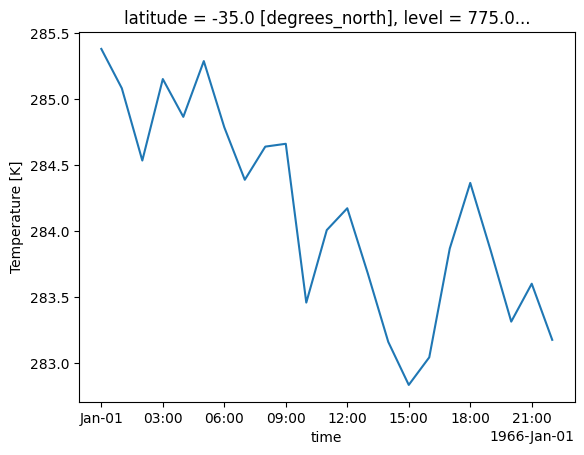

In [94]:
%%timeit -r1 -n1 -o
SC_ds.T.isel(time=slice(0,23),level=27,latitude=500, longitude=500).plot()

In [95]:
SC_timeseries_KC = _.average

491 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 491 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

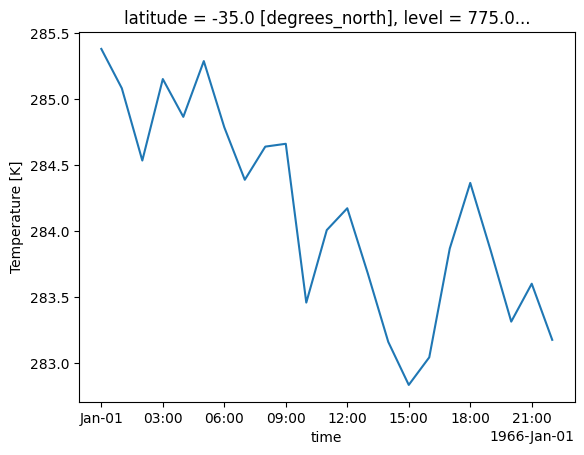

In [96]:
%%timeit -r1 -n1 -o
EC_ds.T.isel(time=slice(0,23),level=27,latitude=500, longitude=500).plot()

In [97]:
EC_timeseries_KC = _.average

<Axes: >

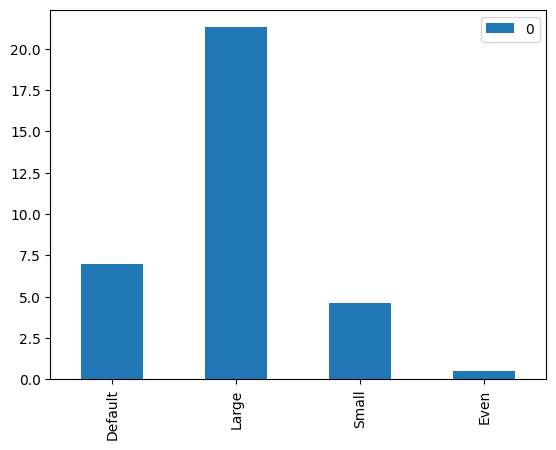

In [98]:
df = pandas.DataFrame(data=[DC_timeseries_KC,LC_timeseries_KC,SC_timeseries_KC,EC_timeseries_KC],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

<Axes: ylabel='time (s)'>

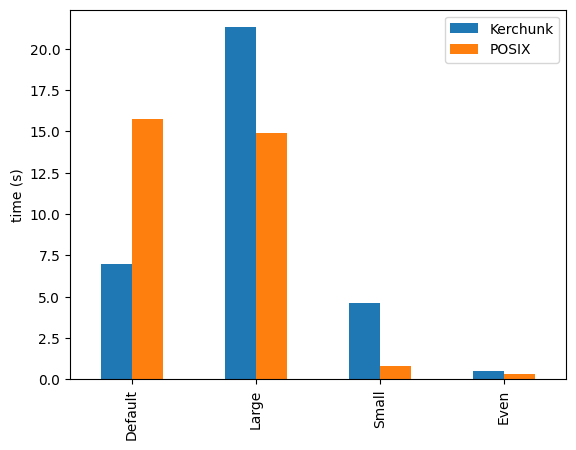

In [167]:
xlabels = ['Default', 'Large', 'Small', 'Even']
df = pandas.DataFrame(data=[[DC_timeseries_KC,DC_timeseries], [LC_timeseries_KC, LC_timeseries], [SC_timeseries_KC,SC_timeseries], [EC_timeseries_KC,EC_timeseries]],
                index=xlabels, columns=['Kerchunk','POSIX'])
df.plot(kind='bar',  ylabel='time (s)')

### Full file

In [100]:
%%timeit -r1 -n1 -o
print(DC_ds.T.isel(time=slice(0,23)).mean().compute())

<xarray.DataArray 'T' ()> Size: 4B
array(246.62494, dtype=float32)
8.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 8.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [112]:
DC_full_KC = _.average

In [102]:
%%timeit -r1 -n1 -o
print(LC_ds.T.isel(time=slice(0,23)).mean().compute(scheduler='single-threaded'))

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/dask/base.py:1402: UserWarning: Running on a single-machine scheduler when a distributed client is active might lead to unexpected results.
  warnings.warn(


<xarray.DataArray 'T' ()> Size: 4B
array(246.62407, dtype=float32)
28.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 28.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [103]:
LC_full_KC = _.average

In [104]:
%%timeit -r1 -n1 -o
print(SC_ds.T.isel(time=slice(0,23)).mean().compute())

/glade/u/home/rpconroy/catalog/venv2/lib/python3.9/site-packages/distributed/client.py:3161: UserWarning: Sending large graph of size 22.02 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


<xarray.DataArray 'T' ()> Size: 4B
array(246.62476, dtype=float32)
27min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 27min 38s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [105]:
SC_full_KC = _.average

In [106]:
%%timeit -r1 -n1 -o
print(EC_ds.T.isel(time=slice(25,47)).mean().compute())

<xarray.DataArray 'T' ()> Size: 4B
array(246.61394, dtype=float32)
15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 15 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [107]:
EC_full_KC = _.average

<Axes: >

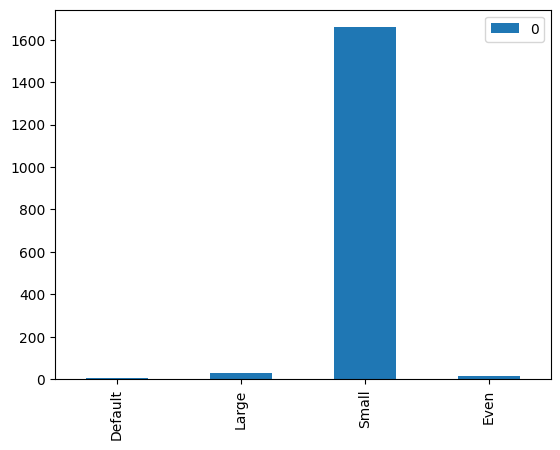

In [113]:
df = pandas.DataFrame(data=[DC_full_KC,LC_full_KC,SC_full_KC,EC_full_KC],
                index=['Default','Large','Small','Even'])
df.plot(kind='bar')

# OSDF Tests

In [6]:
catalog_root = 'https://data.rda.ucar.edu/harshah/rpconroy/era5_chunks/'                          
LC_ds_DTN = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'big_chunks-remote.json'}, 'consolidated':False},chunks=False)
LC_ds_OSDF = xarray.open_dataset('reference://', engine='zarr', 
                         backend_kwargs={'storage_options':{"fo":catalog_root+'big_chunks-remoteosdf.json'}, 'consolidated':False},chunks=False)

In [7]:
%%timeit -r1 -n1 -o
for i in range(10):
    LC_ds_DTN.isel(time=25*i).mean().compute(scheduler='single-threaded')

3min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 3min 41s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [8]:
DTN_time = _.average

In [9]:
%%timeit -r1 -n1 -o
for i in range(10):
    LC_ds_OSDF.isel(time=25*i).mean().compute(scheduler='single-threaded')

13min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


<TimeitResult : 13min 30s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)>

In [10]:
OSDF_time = _.average

<Axes: >

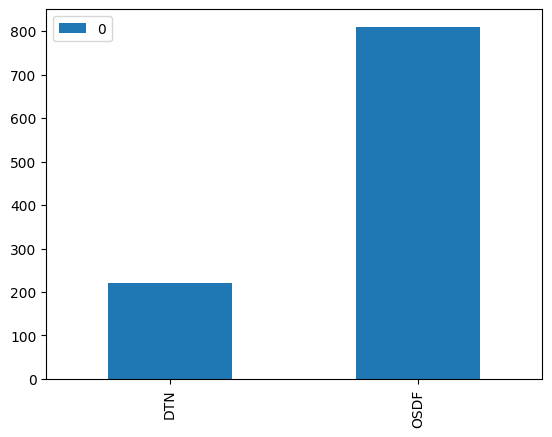

In [11]:
df = pandas.DataFrame(data=[DTN_time,OSDF_time],
                index=['DTN', 'OSDF'])
df.plot(kind='bar')